# Retail Sales Forecasting

### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

# CatBoost is a high-performance open source library for gradient boosting on decision trees
from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# shap is a unified approach to explain the output of any machine learning model.
import shap
shap.initjs()

### Read DataSet

In [2]:
data = pd.read_csv("E:/AMotefaker/ABC/Data Analyst/Sales Data Analysis/Retail Sales Forecasting/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})

In [3]:
data.shape

(541909, 8)

- The data has 541909 entries and 8 variables.

### Familiarity with data

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


- We can see that the datafile has information given for each single transaction. 
- Take a look at the InvoiceNo and the CustomerID of the first entries. Here we can see that one customer with ID 17850 of the United Kingdom made a single order that has the InvoideNo 536365.
- The customer ordered several products with different stockcodes, descriptions, unit prices and quantities. 
- We can see that the InvoiceDate was the same for these products.

### Data Exploration

#### Missing values 

In [5]:
# How many % of missing values do we have for each feature?
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

- Almost 25 % of the customers are unknown! That's very strange. 
- In addition we have 0.2 % of missing descriptions. This looks dirty.

##### Let's gain a further impression by considering some examples:

#### Missing descriptions

In [6]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [7]:
# How often do we miss the customer as well?
data[data.Description.isnull()].CustomerID.isnull().value_counts()

True    1454
Name: CustomerID, dtype: int64

In [8]:
# unit price?
data[data.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

- In cases of missing descriptions we always miss the customer and the unit price as well. Why does the retailer records such kind of entries without a further description?
-  It seems that there is no sophisticated procedure how to deal with and record such kind of transactions. This is already a hint that we could expect strange entries in our data and that it can be difficult to detect them!

#### Missing Customer IDs

In [9]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [10]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


- The price and the quantities of entries without a customer ID can show extreme outliers. 
- As we might want to create features later on that are based on historical prices and sold quantities, this is very disruptive. 
- Our first advice for the retailer is to setup strategies for transactions that are somehow faulty or special. 
- Why is it possible for a transaction to be without a customer ID? Perhaps you can purchase as a quest but then it would of a good and clean style to plugin a special ID that indicates that this one is a guest.

#### Hidden missing descriptions

In [11]:
# Can we find "nan"-Strings?
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

In [12]:
# Can we find empty ""-strings?
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    540455
Name: lowercase_descriptions, dtype: int64

#### We found additional, hidden nan-values that show a string "nan" instead of a nan-value. Let's transform them to NaN:

In [13]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

- We don't know why customers or descriptions are missing and we have seen strange outliers in quantities and prices as well as zero prices.
- Drop all of these occurrences.

In [14]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

In [15]:
# Is there a missing value left?
data.isnull().sum().sum()

0

#### The Time period 

In [16]:
# How long is the period in days?
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [17]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


#### The invoice number

In [18]:
# How many different invoice numbers do we have?
data.InvoiceNo.nunique()

22186

#### In the data description, we can find that a canceled transaction starts with a "C" in front of it. Let's create a feature to easily filter out these cases:

In [19]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

False    97.81007
True      2.18993
Name: IsCancelled, dtype: float64

- About 2.2% of all entries are cancellations.

In [20]:
data.loc[data.IsCancelled==True].describe()

,Quantity,UnitPrice
count,8896.000000,8896.000000
mean,-30.882981,18.862815
std,1170.746458,444.590459
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


- All cancellations have negative quantities but positive, non-zero unit prices. 
- Given this data, we are not easily able to understand why a customer made a return and it's very difficult to predict such cases as there could be several, hidden reasons why a cancellation was done.
- Let's drop them:

In [21]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

#### Stock Codes

In [22]:
# How many unique stockcodes do we have?
data.StockCode.nunique()

3663

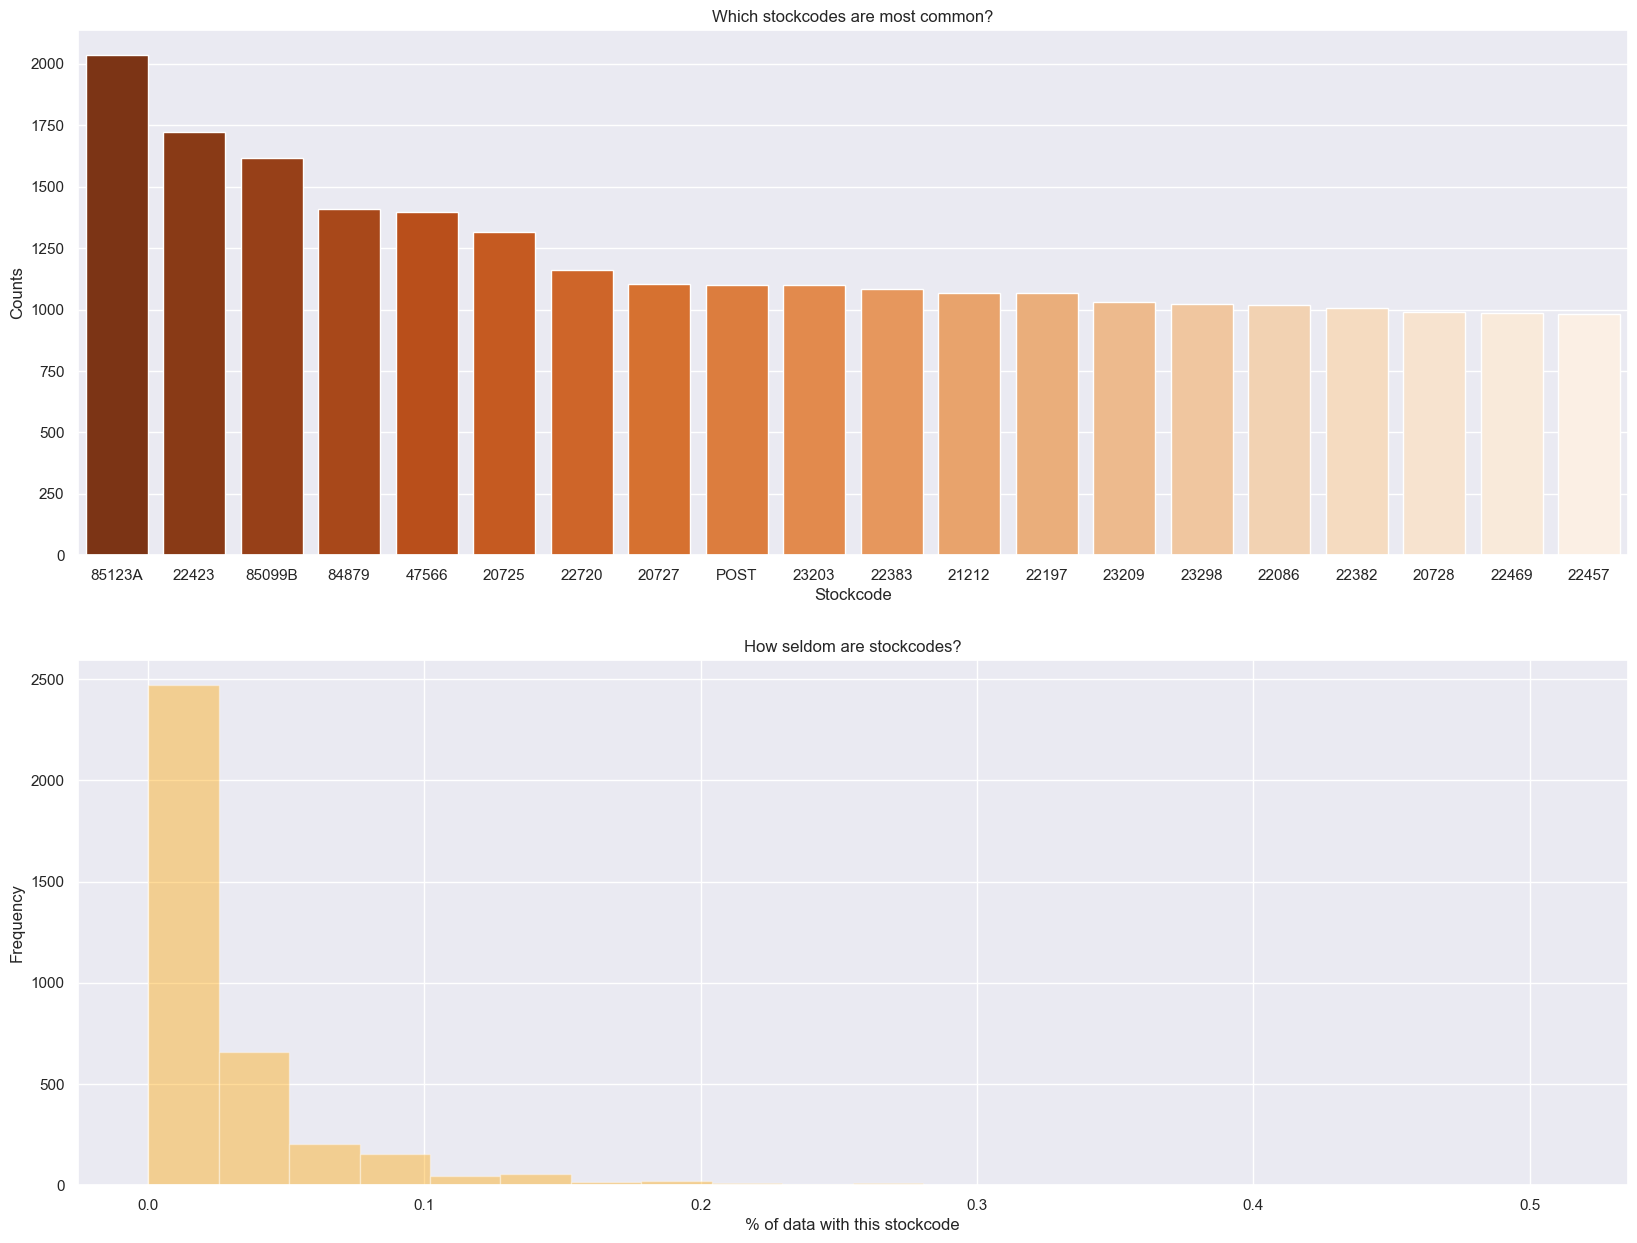

In [25]:
# Which stock codes are most common?
# How seldom are stock codes?
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

#### Tips:
- Do you have the POST in the most common stock code counts?! 
- Hence we could expect strange occurrences not only in the descriptions and customers but also in the stock code. 
- Its code is shorter than the others as well as not numeric.
- Most stock codes are very seldom. This indicates that the retailer sells many different products and that there is no strong specialization of a specific stock code. Nevertheless we have to be careful as this must not mean that the retailer is not specialized given a specific product type. 
- The stock code could be a very detailed indicator that does not yield information about the type, for example, water bottles may have very different variants in color, name, and shapes but they are all water bottles.

#### Count the number of numeric chars in and the length of the stock code:

In [34]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

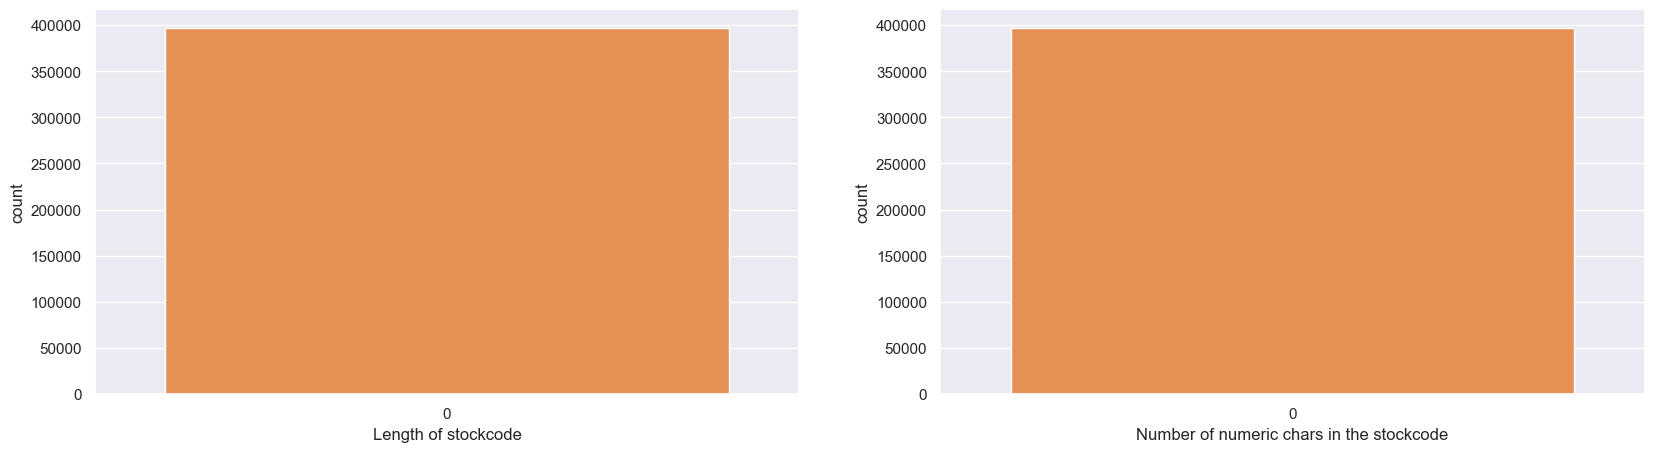

In [35]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data["StockCodeLength"], palette="Oranges_r", ax=ax[0])
sns.countplot(data["nNumericStockCode"], palette="Oranges_r", ax=ax[1])
ax[0].set_xlabel("Length of stockcode")
ax[1].set_xlabel("Number of numeric chars in the stockcode");

- Even though the majority of samples has a stockcode that consists of 5 numeric chars, we can see that there are other occurences as well.
- The length can vary between 1 and 12 and there are stockcodes with no numeric chars at all!

In [36]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

- Something that we don't want to predict. 
- This indicates that the retailer does not separate well between special kinds of transactions and valid customer-retailer transactions. 
- Let's drop all of these occurrences: